## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
# importing the libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
# load the data into data frame 
df = pd.read_csv('ab_data.csv')
# get the first 5 rows from the data
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
# get number of time when control don't match with old page 
control = df.query("group == 'control' and landing_page != 'old_page' ").count()[0]  
# get number of time when control don't match with new page
treatment = df.query("group == 'treatment' and landing_page != 'new_page' ").count()[0]
#sum the values
control + treatment

3893

f. Do any of the rows have missing values?

In [8]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# filtering the data t
query1 = df.query("group == 'control' and landing_page == 'old_page' ") 
query2 =  df.query("group == 'treatment' and landing_page == 'new_page' ")
# group the data in new dataframe 
df2 = pd.merge (query1,query2,how='outer')

df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
# count duplicate
df2.user_id.duplicated().sum()

1

- b. There is one **user_id** repeated in **df2**.  What is it?
- c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
146678,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates(subset= 'user_id',inplace=True)

In [14]:
df2.user_id.duplicated().sum() # check duplicate is removed 

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2[df2['group']=='control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
len(df2[df2['landing_page']=='new_page']) / len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

<p/> 
The probability of individual converting in the control group is 0.1203, and the probability of individual converting in the treatment group
is 0.1188 so according to  this analysis that the conversion rate is similar in both cases so it's important to consider other factors  

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} <= 0 $$
$$H_1: p_{new} - p_{old} > 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
# get the p_new
p_new = len(df2.query( 'converted==1'))/len(df2)
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
# get teh p_old
p_old = len(df2.query( 'converted==1'))/len(df2)
p_old

0.11959708724499628

In [21]:
# get the convert rate 
convert = p_new - p_old 
convert

0.0

### under the null p_old and p_new  is equal  

c. What is $n_{new}$?

In [22]:
# get the n_new
n_new = len(df.query("landing_page == 'new_page'"))
n_new

147239

d. What is $n_{old}$?

In [23]:
# get the n_old

n_old = len(df.query("landing_page == 'old_page'"))
n_old

147239

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
# simulate the convert rate in the new page
converted_new_page = np.random.choice([0,1], n_new , p =[p_new,1-p_new] )

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
# simulate the convert rate in the old page
converted_old_page = np.random.choice([0,1], n_old , p =[p_old,1-p_old] )

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
# get the diffrence between p_new and p_old 
obs_diff =  converted_new_page.mean()- converted_old_page.mean()
obs_diff

-6.112510951583605e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
# boot_strap simulate the diff in  the old page and teh new page 
p_diffs = []
for i in range(10000):
    new_page = np.random.choice([0,1], n_new ,replace =True, p =[p_new,1-p_new] )
    old_page = np.random.choice([0,1], n_old , replace =True , p =[p_old,1-p_old] )
    p_diffs.append(new_page.mean() - old_page.mean())
    
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

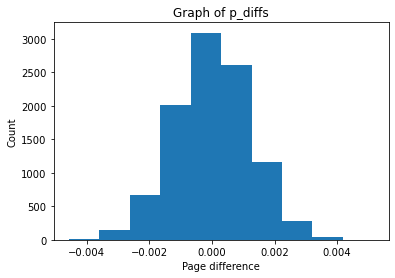

In [28]:
p_diffs = np.array(p_diffs)
#histogram of p_diff 
plt.hist(p_diffs)
plt.title('Graph of p_diffs')#title of graphs
plt.xlabel('Page difference') # x-label of graphs
plt.ylabel('Count'); # y-label of graphs

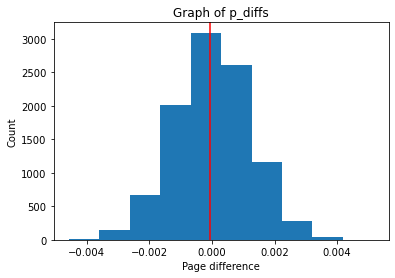

In [29]:
plt.hist(p_diffs);

plt.title('Graph of p_diffs') #title of graphs
plt.xlabel('Page difference') # x-label of graphs
plt.ylabel('Count') # y-label of graphs

plt.axvline(x= obs_diff, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
#get the proportion of the new page from the pramter
new_p = df2.query("landing_page == 'new_page'")
new_p=new_p['converted'].mean()

#get the proportion of the old page from the pramter
old_p = df2.query("landing_page == 'old_page'")
old_p= old_p['converted'].mean()
# get the diff from the p of old page and the p of  new page
actual_diff = new_p - old_p
# loop to iterate in the  p_diffs to get the p_value
count = 0
for i in p_diffs:
    if i > actual_diff:
        count = count+1
        
proportion =count/(len(p_diffs))
proportion

0.9076

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value calculated the p-value. For accepting null hypothesis p-value should be greater than suggested p-value. and we find  that almost 90% of the population is above the real diffrence which suggested that new-page is not doing significantly better than the old page. New page is worse than old page, so we fail to reject the null  and stick to the null hyposthesis as p-value is large.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
#rows converted with old_page
convert_old = len(df2.query('converted==1 and landing_page=="old_page"')) 
#rows converted with new_page
convert_new = len(df2.query('converted==1 and landing_page=="new_page"')) 
#rows_associated with old_page
n_old = len(df2.query('landing_page=="old_page"'))
#rows associated with new_page 
n_new = len(df2.query('landing_page=="new_page"'))
n_new

145310

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 
print(z_score ,p_value)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [33]:
#how significant our z_score is
signifcant = norm.cdf(z_score) 
#critical value of 95% confidence
critical= norm.ppf(1-(0.05)) 

signifcant , critical

(0.9050583127590245, 1.6448536269514722)

**z_score is less than critical value of 95% confidence. Hence we fail to reject null hypothesis. Therefore the conclusion is same as part j that we accept null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We use : Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified  to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
# add an intercept
df2['intercept'] = 1 
# get the dummy variable
df2['ab_page']  = pd.get_dummies(df2['group'])['treatment']
#check the data
df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [35]:
lm = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 07 Feb 2022   Pseudo R-squ.:               8.077e-06
Time:                        11:21:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**In Logistic regression** 

$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} != 0$$
**A/B test**
$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} > 0$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Additional factors should be added into the regression models they may also influence the conversions .**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [38]:
### Create the necessary dummy variables
df_new[['US','UK']] = pd.get_dummies(df_new['country'])[['US','UK']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [39]:
df_new['US_ab']=df_new['US']*df_new['ab_page']
df_new['UK_ab']=df_new['UK']*df_new['ab_page']


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
logit2 = sm.Logit(df_new['converted'],df_new[['intercept', 'ab_page', 'US', 'UK', 'US_ab', 'UK_ab']])
logit2

In [41]:
result = logit2.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [42]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 07 Feb 2022   Pseudo R-squ.:               3.482e-05
Time:                        11:21:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US_ab          0.0469      0.054      0.872      0.383      -0.059       0.152
UK_ab          0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions :
None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.